In [227]:
# barplot
# https://12jeong.github.io/python-barplot/

# plot color
# https://matplotlib.org/stable/gallery/color/named_colors.html

# 신뢰 구간
# https://angie-gil.medium.com/평점-순으로-정렬하지-않는-법-이론편-9ced2f26bc4b

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

In [96]:
train_file = "./train_data.csv"
track_file = "./course.csv"

drop_columns = [
    'index',
    # 'track_K',
]
df_train = pd.read_csv(train_file)
df_train = df_train.drop(drop_columns, axis=1)

drop_columns = [
    'idx',
    # 'grand_prix_K',
    # 'cup_K',
    # 'track_name_K',
]
df_track = pd.read_csv(track_file)
df_track = df_track.drop(drop_columns, axis=1)

In [97]:
df_train.head()

,date,round,game_count,game_goal,cur_game_count,win_odds,lose_odds,track_K,track_E,cc,part_people,rank,prefix_rank,odds_result,significant,RESULT
0,20220204,1,3,15,1,4.71,1.27,와리오 스노 마운틴,Mount Wario,150,10,10,10,straight up,NaN,False
1,20220204,1,3,15,2,4.71,1.27,드래곤 드리프트 로드,Dragon Driftway,mirror,12,7,17,straight up,NaN,False
2,20220204,2,3,15,1,7.04,1.17,와리오 스노 마운틴,Mount Wario,150,11,2,2,underdog,NaN,True
3,20220204,2,3,15,2,7.04,1.17,3DS DK 정글,3DS DK Jungle,150,11,5,7,underdog,NaN,True
4,20220204,2,3,15,3,7.04,1.17,DS 와리오 스타디움,DS Wario Stardium,150,12,5,12,underdog,NaN,True


In [98]:
df_track.head()

,grand_prix_K,grand_prix_E,cup_K,cup_E,track_name_K,track_name_E,significant
0,니트로 그랑프리,Nitro Grand Prix,버섯 컵,Mushroom Cup,마리오 카트 스타디움,Mario Kart Stadium,NaN
1,니트로 그랑프리,Nitro Grand Prix,버섯 컵,Mushroom Cup,워터 파크,Water Park,NaN
2,니트로 그랑프리,Nitro Grand Prix,버섯 컵,Mushroom Cup,스위트 캐니언,Sweet Sweet Canyon,NaN
3,니트로 그랑프리,Nitro Grand Prix,버섯 컵,Mushroom Cup,쿵쿵 유적,Thwomp Ruins,NaN
4,니트로 그랑프리,Nitro Grand Prix,플라워 컵,Flower Cup,마리오 서킷,Mario Circuit,NaN


### 코스별 성공/실패 비율 확인을 위한 dict 선언

In [99]:
track_dict = dict()

for track in df_track['track_name_K']:
    track_dict[track] = dict()
    track_dict[track][True] = track_dict[track][False] = 0

### df_train에서 성공/실패 비율 세기

In [155]:
df_groupby_track = df_train.groupby(['track_K', 'RESULT']).count()

iterable = zip(df_groupby_track['date'].index, df_groupby_track['date'])
for (track, b), value in iterable:
    track_dict[track][b] = value

### plt로 그래프를 그리기 위해 새로운 df 생성

In [202]:
track_name = list()
bTrue, bFalse = list(), list()

for track, value in track_dict.items():
    t = value[True]
    f = value[False]
    
    track_name.append(track)
    bTrue.append(t)
    bFalse.append(f)
    
# track distribution
df_td = pd.DataFrame({
    "성공": bTrue,
    "실패": bFalse,
})

# index에 track 이름 넣기
df_td.index = track_name

# 한 번도 하지 않은 track 제거하기
df_td = df_td.loc[~(df_td == 0).all(axis=1)]
df_td['win_ratio'] = df_td['성공'] / (df_td['성공'] + df_td['실패'])
df_td

,성공,실패,win_ratio
마리오 카트 스타디움,4,6,0.400000
워터 파크,1,2,0.333333
스위트 캐니언,3,6,0.333333
쿵쿵 유적,3,9,0.250000
마리오 서킷,3,11,0.214286
...,...,...,...
Tour 로마 아반티,0,1,0.000000
GC DK 마운틴,0,1,0.000000
Tour 마드리드 그란데,1,0,1.000000
SFC 쿠파 성 3,0,2,0.000000


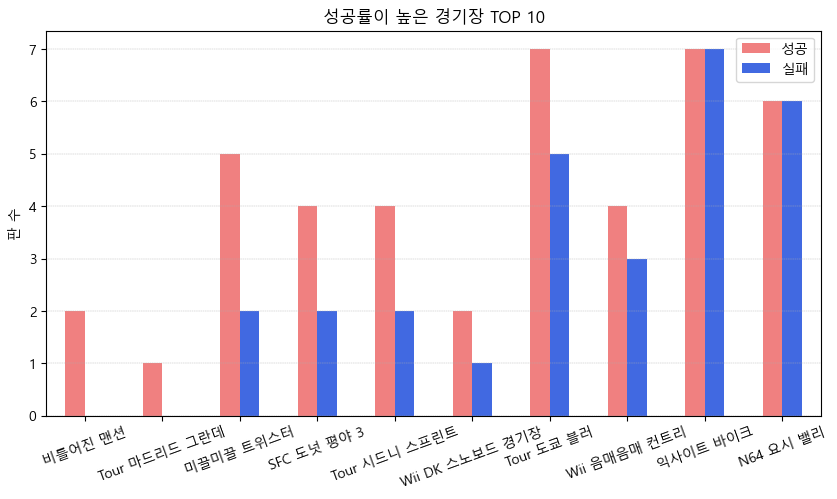

In [233]:
df_td = df_td.sort_values(['win_ratio', '성공'], ascending=False)

df_td.head(10).plot.bar(
    y=['성공', '실패'],
    color=['lightcoral', 'royalblue'],
    figsize=(10, 5),
    rot=20,
)

plt.title("성공률이 높은 경기장 TOP 10")
plt.ylabel("판 수")
plt.grid(True, linestyle='--', linewidth=0.3, axis='y')

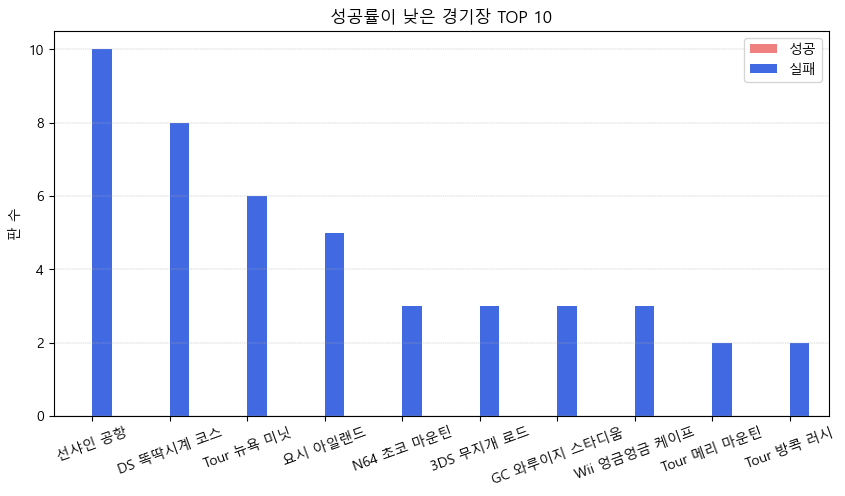

In [232]:
df_td = df_td.sort_values(['win_ratio', '실패'], ascending=[True, False])

df_td.head(10).plot.bar(
    y=['성공', '실패'],
    color=['lightcoral', 'royalblue'],
    figsize=(10, 5),
    rot=20,
)

plt.title("성공률이 낮은 경기장 TOP 10")
plt.ylabel("판 수")
plt.grid(True, linestyle='--', linewidth=0.3, axis='y')

### 코스별 집계 함수 결과 확인하기 & 파생 변수 만들기

In [240]:
df_rank = df_train.groupby(['track_K'])['rank'].agg([
    'mean', 'max', 'min', 'count', 'std',
])

df_rank['frequency'] = df_rank['count'] / sum(df_rank['count'])
df_rank['coef_var'] = df_rank['std'] / df_rank['mean']
df_rank['win_ratio'] = df_rank.index.map(df_td['win_ratio'])
df_rank['standard'] = df_rank['frequency'] * df_rank['win_ratio']
df_rank.head()

,mean,max,min,count,std,frequency,coef_var,win_ratio,standard
track_K,,,,,,,,,
3DS DK 정글,5.714286,12,1,7,3.450328,0.011076,0.603807,0.428571,0.004747
3DS 네오 쿠파 시티,7.083333,11,4,12,2.678478,0.018987,0.378138,0.250000,0.004747
3DS 록 록 마운틴,7.000000,12,4,5,3.162278,0.007911,0.451754,0.200000,0.001582
3DS 무지개 로드,7.000000,11,3,3,4.000000,0.004747,0.571429,0.000000,0.000000
3DS 뮤직 파크,4.333333,7,2,3,2.516611,0.004747,0.580756,0.333333,0.001582


### wilson score 점수 반영하기

In [211]:
from scipy import stats
import math

def handmade_wilson_score(pos: int, total: int) -> float:
    confidence = 0.95
    z = stats.norm.ppf(1 - (1-confidence) / 2)
    phat = 1.0 * pos / total
    lower_bound = (phat + z*z/(2*total) - z * math.sqrt((phat*(1-phat)+z*z/(4*total))/total))/(1+z*z/total)
    return lower_bound


from statsmodels.stats.proportion import proportion_confint

def wilson_score(pos: int, total: int) -> float:
    return proportion_confint(pos, total, method='wilson')

In [239]:
def get_lower_bound(row):
    return proportion_confint(row['win_count'], row['count'], method='wilson')[0]

df_rank['win_count'] = df_rank.index.map(df_td['성공'])
df_rank['lower_bound'] = df_rank.apply(get_lower_bound, axis=1)
df_rank.head()

,mean,max,min,count,std,frequency,coef_var,win_ratio,standard,win_count,lower_bound
track_K,,,,,,,,,,,
미끌미끌 트위스터,5.000000,8,3,7,1.632993,0.011076,0.326599,0.714286,0.007911,5,0.358934
비틀어진 맨션,1.500000,2,1,2,0.707107,0.003165,0.471405,1.000000,0.003165,2,0.342380
SFC 도넛 평야 3,5.000000,12,1,6,3.741657,0.009494,0.748331,0.666667,0.006329,4,0.299993
Tour 도쿄 블러,4.153846,12,1,13,3.715870,0.020570,0.894561,0.583333,0.011999,7,0.291438
N64 요시 밸리,6.833333,12,1,12,3.099365,0.018987,0.453566,0.500000,0.009494,6,0.253782


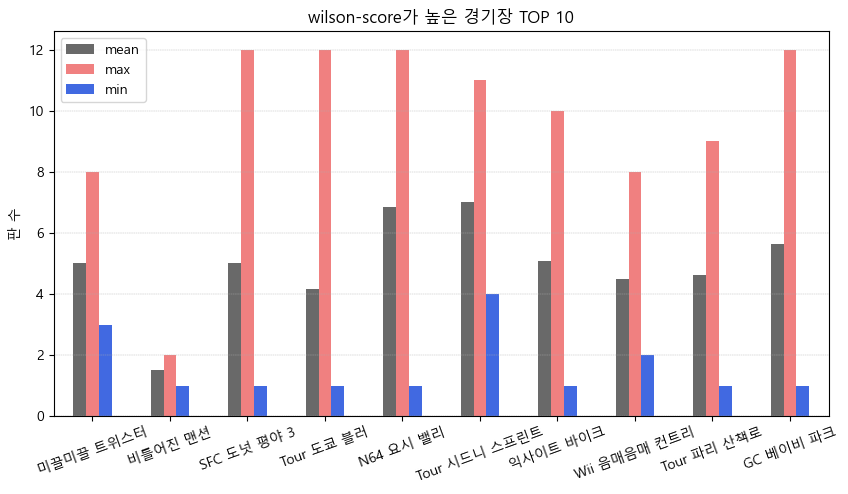

In [238]:
df_rank = df_rank.sort_values('lower_bound', ascending=False)

df_rank.head(10).plot.bar(
    y = ['mean', 'max', 'min'],
    color = ['dimgray', 'lightcoral', 'royalblue'],
    figsize = (10, 5),
    rot = 20,
)

plt.title("wilson-score가 높은 경기장 TOP 10")
plt.xlabel("")
plt.ylabel("판 수")
plt.grid(True, linestyle='--', linewidth=0.3, axis='y')